image balancing per class without augmentation

image balancing with augmentation - 
1. balancing is done usingn average of images per class. then the class has lower images, generate new images using augmentation
2. for the class has more number of images, down sampling is done for them to randomly select the images.

Original image counts per class:
Acne and Rosacea Photos: 840
Poison Ivy Photos and other Contact Dermatitis: 260
Vascular Tumors: 482
Urticaria Hives: 212
Atopic Dermatitis Photos: 489
Psoriasis pictures Lichen Planus and related diseases: 1405
Melanoma Skin Cancer Nevi and Moles: 463
Eczema Photos: 1235
Herpes HPV and other STDs Photos: 405
Warts Molluscum and other Viral Infections: 1086


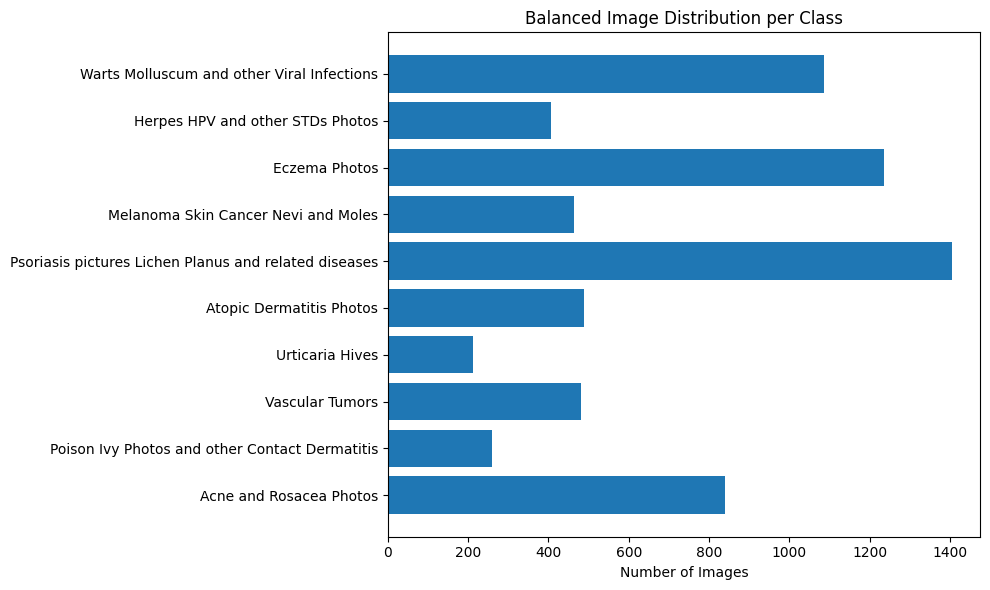

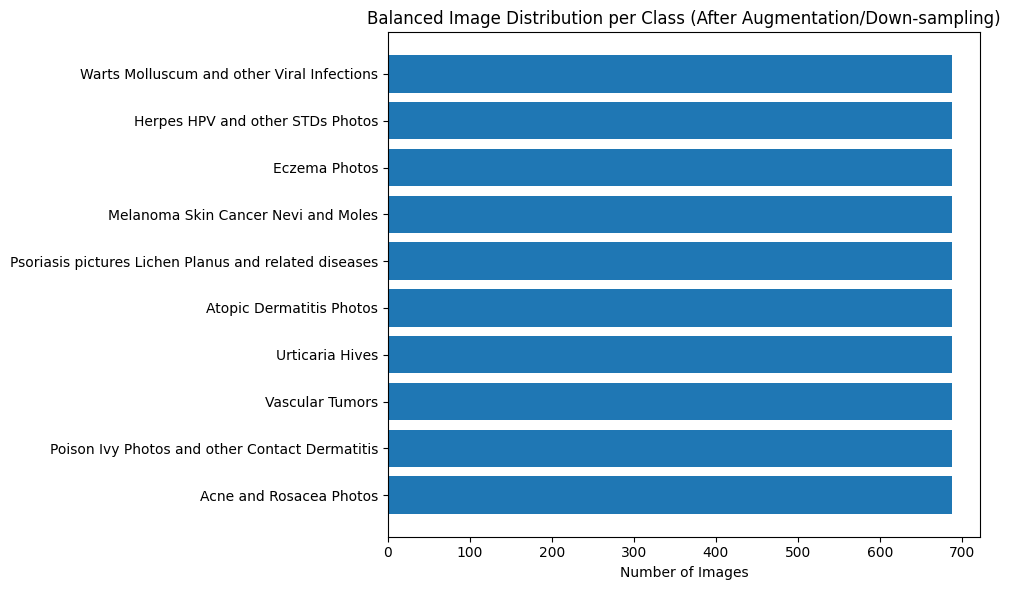

Final image counts per class:
Acne and Rosacea Photos: 688
Poison Ivy Photos and other Contact Dermatitis: 688
Vascular Tumors: 688
Urticaria Hives: 688
Atopic Dermatitis Photos: 688
Psoriasis pictures Lichen Planus and related diseases: 688
Melanoma Skin Cancer Nevi and Moles: 688
Eczema Photos: 688
Herpes HPV and other STDs Photos: 688
Warts Molluscum and other Viral Infections: 688


In [1]:
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt

def balance_dataset(train_folder, balanced_folder, max_augmentations_per_image=5):
    # Create balanced folder
    os.makedirs(balanced_folder, exist_ok=True)
    
    # List classes and calculate image counts
    disease_classes = os.listdir(train_folder)
    image_counts = {disease: len(os.listdir(os.path.join(train_folder, disease))) for disease in disease_classes}
    
    # Calculate the average number of images per class
    total_images = sum(image_counts.values())
    num_classes = len(disease_classes)
    average_images = round(total_images / num_classes)
    
    # Print original image counts per class before augmentation
    print("Original image counts per class:")
    for disease, count in image_counts.items():
        print(f"{disease}: {count}")

    # Visualization of balanced dataset
    img_counts = [len(os.listdir(os.path.join(train_folder, disease))) for disease in disease_classes]
    plt.figure(figsize=(10, 6))
    plt.barh(disease_classes, img_counts)
    plt.xlabel('Number of Images')
    plt.title('Balanced Image Distribution per Class')
    plt.tight_layout()
    plt.show()
    
    # Initialize data generator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Process each disease class
    for disease in disease_classes:
        class_folder = os.path.join(train_folder, disease)
        balanced_class_folder = os.path.join(balanced_folder, disease)
        os.makedirs(balanced_class_folder, exist_ok=True)
        
        images = os.listdir(class_folder)
        
        # Down-sample for classes with more images than the average
        if len(images) > average_images:
            selected_images = random.sample(images, average_images)  # Select random images
            for image in selected_images:
                shutil.copy(os.path.join(class_folder, image), balanced_class_folder)
        else:
            # Copy existing images if fewer than the average
            for image in images:
                shutil.copy(os.path.join(class_folder, image), balanced_class_folder)
            
            # Augment images to reach the target number
            while len(os.listdir(balanced_class_folder)) < average_images:
                for image in images:
                    # Break if we've reached the target number of images
                    if len(os.listdir(balanced_class_folder)) >= average_images:
                        break
                    
                    img_path = os.path.join(class_folder, image)
                    img = load_img(img_path)
                    x = img_to_array(img)
                    x = x.reshape((1,) + x.shape)
                    
                    # Generate augmented images per original image
                    augmented_count = 0
                    for batch in datagen.flow(x, batch_size=1, save_to_dir=balanced_class_folder,
                                               save_prefix='aug', save_format='jpeg'):
                        augmented_count += 1
                        # Break if target number of images is reached or we hit max augmentation limit
                        if len(os.listdir(balanced_class_folder)) >= average_images or augmented_count >= max_augmentations_per_image:
                            break
    

    balanced_counts = [average_images for disease in disease_classes]  # All should be equal to average_images now
    plt.figure(figsize=(10, 6))
    plt.barh(disease_classes, balanced_counts)
    plt.xlabel('Number of Images')
    plt.title('Balanced Image Distribution per Class (After Augmentation/Down-sampling)')
    plt.tight_layout()
    plt.show()
    
    # Print out the final image counts (after augmentation) per class
    print("Final image counts per class:")
    for disease in disease_classes:
        print(f"{disease}: {average_images}")  # All should be equal to average_images now

# Set paths
train_folder = "/kaggle/input/finalfile/train"
balanced_folder = "/kaggle/working/balanced_train"

# Run the balancing process
balance_dataset(train_folder, balanced_folder)


In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2

# Function to adjust brightness
def adjust_brightness(image, factor=1.2):
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

# Function to preprocess balanced data
def preprocess_and_save_data(balanced_folder, output_folder, img_size=(128, 128), brightness_factor=1.2):
    # Initialize containers for images and labels
    images = []
    labels = []
    class_names = sorted(os.listdir(balanced_folder))  # To keep consistent ordering of classes
    class_mapping = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    print("Loading, preprocessing, and saving images from balanced data...")
    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(balanced_folder, class_name)
        image_files = os.listdir(class_folder)
        
        # Create corresponding class folder in the output directory
        output_class_folder = os.path.join(output_folder, class_name)
        os.makedirs(output_class_folder, exist_ok=True)
        
        for image_file in image_files:
            img_path = os.path.join(class_folder, image_file)
            # Load and resize the image
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            
            # Apply brightness adjustment
            img_array = adjust_brightness(img_array, factor=brightness_factor)
            
            # Normalize pixel values to [0, 1]
            img_array_normalized = img_array / 255.0
            images.append(img_array_normalized)
            labels.append(class_mapping[class_name])  # Add numeric label
            
            # Save the preprocessed image
            output_img_path = os.path.join(output_class_folder, image_file)
            cv2.imwrite(output_img_path, cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR))  # Save in BGR format
            
    # Convert to numpy arrays
    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int")
    
    # One-hot encode the labels
    labels_one_hot = to_categorical(labels, num_classes=len(class_names))
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
    
    print(f"Data split: {len(X_train)} training samples, {len(X_val)} validation samples")
    print(f"Class mapping: {class_mapping}")
    
    # Optional data augmentation for the training set
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    
    # Validation data generator (only rescaling)
    val_datagen = ImageDataGenerator()
    
    # Create training and validation generators
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
    
    return train_generator, val_generator, class_mapping

# Set the balanced folder path
balanced_folder = "/kaggle/working/balanced_train"
output_folder = "/kaggle/working/preprocessed_data"  # Folder to save preprocessed images

# Preprocess the data and save preprocessed images
train_generator, val_generator, class_mapping = preprocess_and_save_data(
    balanced_folder, 
    output_folder, 
    img_size=(128, 128), 
    brightness_factor=1.2  # Adjust this factor to tune brightness enhancement
)

# Verify the class mapping
print(f"Class mapping: {class_mapping}")


Loading, preprocessing, and saving images from balanced data...
Data split: 5504 training samples, 1376 validation samples
Class mapping: {'Acne and Rosacea Photos': 0, 'Atopic Dermatitis Photos': 1, 'Eczema Photos': 2, 'Herpes HPV and other STDs Photos': 3, 'Melanoma Skin Cancer Nevi and Moles': 4, 'Poison Ivy Photos and other Contact Dermatitis': 5, 'Psoriasis pictures Lichen Planus and related diseases': 6, 'Urticaria Hives': 7, 'Vascular Tumors': 8, 'Warts Molluscum and other Viral Infections': 9}
Class mapping: {'Acne and Rosacea Photos': 0, 'Atopic Dermatitis Photos': 1, 'Eczema Photos': 2, 'Herpes HPV and other STDs Photos': 3, 'Melanoma Skin Cancer Nevi and Moles': 4, 'Poison Ivy Photos and other Contact Dermatitis': 5, 'Psoriasis pictures Lichen Planus and related diseases': 6, 'Urticaria Hives': 7, 'Vascular Tumors': 8, 'Warts Molluscum and other Viral Infections': 9}


Found 6880 images belonging to 10 classes.
Found 1743 images belonging to 10 classes.
Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.1315 - loss: 2.2891 - val_accuracy: 0.1779 - val_loss: 2.2136 - learning_rate: 0.0010
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.1731 - loss: 2.2348 - val_accuracy: 0.1492 - val_loss: 2.2110 - learning_rate: 0.0010
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.1865 - loss: 2.1956 - val_accuracy: 0.1882 - val_loss: 2.1538 - learning_rate: 0.0010
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.2138 - loss: 2.1547 - val_accuracy: 0.1968 - val_loss: 2.2166 - learning_rate: 0.0010
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.2367 - loss: 2.1181 - val_accuracy: 0.2404 - val_loss: 2.0893 - learning_rate: 0.0010
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.2401 - loss: 2.1003 - val_accuracy: 0.2473 - val_loss: 2.0770 - learning_rate: 0.0

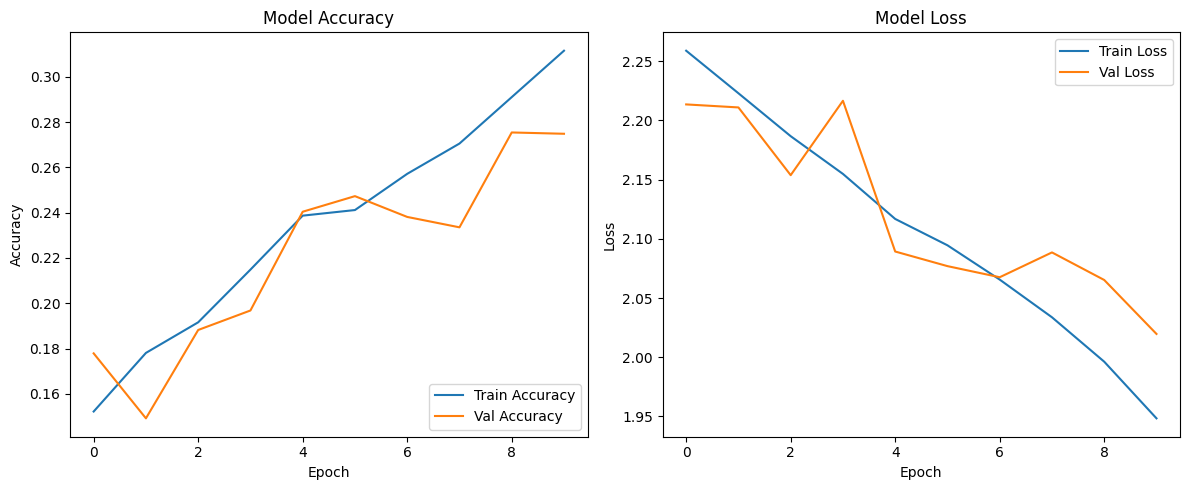

55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 757ms/step - accuracy: 0.3406 - loss: 1.9077
Test Accuracy: 27.48%
Test Loss: 2.0197
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 771ms/step

Classification Report:
                                                       precision    recall  f1-score   support

                              Acne and Rosacea Photos       0.37      0.49      0.42       230
                             Atopic Dermatitis Photos       0.24      0.16      0.19       123
                                        Eczema Photos       0.45      0.27      0.33       309
                     Herpes HPV and other STDs Photos       0.16      0.29      0.21       102
                  Melanoma Skin Cancer Nevi and Moles       0.30      0.53      0.39       116
       Poison Ivy Photos and other Contact Dermatitis       0.08      0.05      0.06        65
Psoriasis pictures Lichen Planus and related diseases       0.36      0.24      0.29       352
                                      Urticaria Hives    

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 10  # Adjust based on your number of classes

# Create ImageDataGenerator instances with proper preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Setup the generators with proper directory structure
# Replace 'path/to/train' and 'path/to/test' with your actual paths
try:
    train_generator = train_datagen.flow_from_directory(
        '/kaggle/working/preprocessed_data',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        '/kaggle/input/finalfile/test',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Important for maintaining order in evaluation
    )
except Exception as e:
    print(f"Error setting up generators: {str(e)}")
    raise

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
]

# Train the model
try:
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=callbacks
    )
except Exception as e:
    print(f"Error during training: {str(e)}")
    raise

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Evaluate and visualize results
try:
    # Plot training history
    plot_history(history)
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Generate predictions
    predictions = model.predict(test_generator)
    y_pred_classes = np.argmax(predictions, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Get class labels
    class_labels = list(test_generator.class_indices.keys())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred_classes))

except Exception as e:
    print(f"Error during evaluation: {str(e)}")
    raise

Found 6880 images belonging to 10 classes.
Found 1743 images belonging to 10 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.2363 - loss: 2.1314 - val_accuracy: 0.3110 - val_loss: 1.9275
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.3628 - loss: 1.8004 - val_accuracy: 0.2892 - val_loss: 2.0361
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.4238 - loss: 1.6827 - val_accuracy: 0.2708 - val_loss: 2.0772
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.4313 - loss: 1.6526 - val_accuracy: 0.3075 - val_loss: 1.9886
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.4505 - loss: 1.6008 - val_accuracy: 0.3351 - val_loss: 1.9004
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.4549 - loss: 1.5648 - val_accuracy: 0.3184 - val_loss: 1.9161
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.4803 - loss: 1.5310 - 

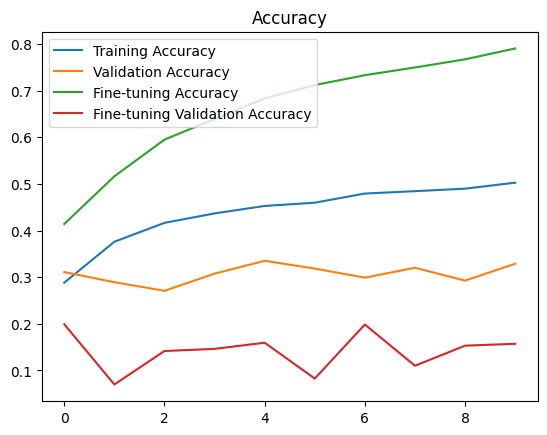

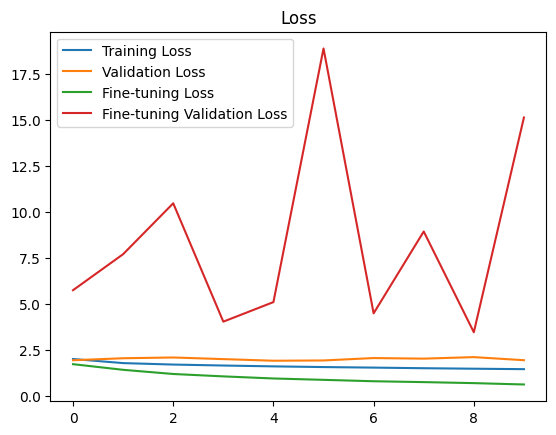

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 10  # Replace with the number of classes in your dataset

# Load and preprocess the dataset
train_data_dir = "/kaggle/working/preprocessed_data"
val_data_dir = "/kaggle/input/finalfile/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Load the pre-trained ResNet-50 model without the top layer
base_model = NASNetMobile(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# Freeze the base model
base_model.trainable = False

# Build the custom model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dense(NUM_CLASSES, activation="softmax")  # Output layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # You can increase the epochs
    validation_data=val_generator
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Plot accuracy and loss
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history_fine.history["accuracy"], label="Fine-tuning Accuracy")
plt.plot(history_fine.history["val_accuracy"], label="Fine-tuning Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history_fine.history["loss"], label="Fine-tuning Loss")
plt.plot(history_fine.history["val_loss"], label="Fine-tuning Validation Loss")
plt.title("Loss")
plt.legend()
plt.show()


from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
)
)
